In [4]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_99/2779030276.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


# 4qubit Grover アルゴリズムの実装


C3Xゲートの実装方法として、
1. Hゲート, CPゲート, CXゲートを用いて4qubitで実装する
2. ビット数を1増やして, CCXゲートを用いて実装する
3. qiskitで実装されているMCTゲートを使う

の3つの方法を試してみます。

In [5]:
def c3x_1(qc, c_list, t):
    a, b, c = c_list

    qc.h(t)
    qc.p(pi/8, a)
    qc.p(pi/8, b)
    qc.p(pi/8, c)
    qc.p(pi/8, t)
    qc.cx(a, b)
    qc.p(-pi/8, b)
    qc.cx(a, b)
    qc.cx(b, c)
    qc.p(-pi/8, c)
    qc.cx(a, c)
    qc.p(pi/8, c)
    qc.cx(b, c)
    qc.p(-pi/8, c)
    qc.cx(a, c)
    qc.cx(c, t)
    qc.p(-pi/8, t)
    qc.cx(b, t)
    qc.p(pi/8, t)
    qc.cx(c, t)
    qc.p(-pi/8, t)
    qc.cx(a, t)
    qc.p(pi/8, t)
    qc.cx(c, t)
    qc.p(-pi/8, t)
    qc.cx(b, t)
    qc.p(pi/8, t)
    qc.cx(c, t)
    qc.p(-pi/8, t)
    qc.cx(a, t)
    qc.h(t)



def c3x_2(qc, c_list, t, a):
    if len(c_list) != 3:
        raise ValueError("制御ビットは3つ指定してください。")
    
    #CCXゲートを使用してC3Xゲートを実装
    qc.barrier()
    qc.ccx(c_list[0], c_list[1], a)
    qc.ccx(c_list[2], a, t)
    qc.ccx(c_list[0], c_list[1], a)
    qc.barrier()
    

def c3x_3(qc, c_list, t):
    if len(c_list) != 3:
        raise ValueError("制御ビットは3つ指定してください。")
    
    #mctゲートを使用してC3Xゲートを実装
    qc.mct(c_list, t)


実装したC3Xゲートを元に、振幅を増幅する回路を組んでいきます。

In [6]:
def make_diffuser(qc, func_number):
    qc.h(range(4))
    qc.x(range(4))
    qc.h(3)
    if func_number == 1:
        c3x_1(qc, [0,1,2],3)
    elif func_number == 2:
        c3x_2(qc, [0,1,2],3,4)
    elif func_number == 3:
        c3x_3(qc, [0,1,2],3)
    qc.h(3)
    qc.x(range(4))
    qc.h(range(4))


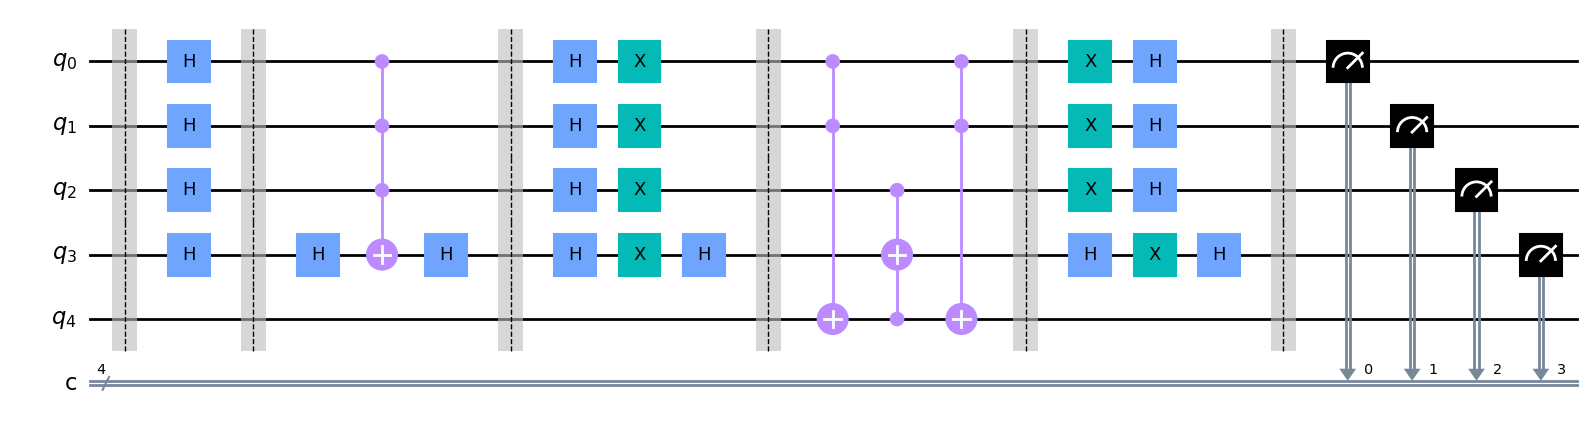

In [7]:
#n回繰り返す回路を作る関数
def repeated_circuit(n, func_number):
    #量子ビット数と古典ビット数
    q = 5
    c = 4
    
    #最初に全ての状態を重ね合わせる
    circ_init = QuantumCircuit(q, c)
    circ_init.barrier()
    circ_init.h(range(4))


    #オラクル回路
    oracle = QuantumCircuit(q, c)
    oracle.barrier()

    #15を解とする
    oracle.h(3)
    oracle.mct([0,1,2],3)
    oracle.h(3)


    #位相回路
    diffuser = QuantumCircuit(q, c)
    diffuser.barrier()
    make_diffuser(diffuser, func_number)

    #グローバーの繰り返し回路
    grover = oracle.compose(diffuser)

    #測定
    meas = QuantumCircuit(q, c)
    meas.barrier()
    meas.measure(range(4),range(4))


    for i in range(0,n):
        circ = circ_init.compose(grover)
    circ = circ.compose(meas)
    return circ


#回路を表示
repeated_circuit(1,2).draw(output='mpl')


In [9]:
#シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')

n = 15 #回路の最大繰り返し回数
func_number = 2 #実装するC3Xゲートの種類

#ショット数、結果の格納庫を用意
shots = 2048
results_sim = []


#回路をシミュレート、測定結果を取得して配列に
for i in range(1,n+1):
    qc = repeated_circuit(i, func_number)
    job_sim = simulator.run(transpile(qc, backend=simulator), shots=shots)
    results_sim.append(job_sim.result().get_counts(qc))

#各状態の確率を格納する配列を用意
probability_sim = []

#結果から確率を計算し、配列に
for counts in results_sim:
    a0 = list(counts.values())
    ntotal = sum(a0)
    p0000 = counts.get('0000', 0) / ntotal
    p0001 = counts.get('0001', 0) / ntotal
    p0010 = counts.get('0010', 0) / ntotal
    p0011 = counts.get('0011', 0) / ntotal
    p0100 = counts.get('0100', 0) / ntotal
    p0101 = counts.get('0101', 0) / ntotal
    p0110 = counts.get('0110', 0) / ntotal
    p0111 = counts.get('0111', 0) / ntotal
    p1000 = counts.get('1000', 0) / ntotal
    p1001 = counts.get('1001', 0) / ntotal
    p1010 = counts.get('1010', 0) / ntotal
    p1011 = counts.get('1011', 0) / ntotal
    p1100 = counts.get('1100', 0) / ntotal
    p1101 = counts.get('1101', 0) / ntotal
    p1110 = counts.get('1110', 0) / ntotal
    p1111 = counts.get('1111', 0) / ntotal
    a = [p0000, p0001, p0010, p0011, p0100, p0101, p0110, p0111, p1000, p1001, p1010, p1011, p1100, p1101, p1110, p1111]
    probability_sim.append(a)

import pandas as pd
df = pd.DataFrame(probability_sim)
# 表示
print(df)

          0         1         2         3         4         5         6   \
0   0.032715  0.034668  0.031250  0.040039  0.031250  0.038574  0.034180   
1   0.028320  0.037598  0.036621  0.028809  0.040039  0.035645  0.031738   
2   0.036133  0.037598  0.035156  0.028320  0.035645  0.037109  0.024414   
3   0.039551  0.027344  0.040039  0.037109  0.032227  0.037109  0.027832   
4   0.034180  0.040039  0.032227  0.036133  0.034180  0.036133  0.038574   
5   0.035156  0.035645  0.029785  0.037109  0.038574  0.038574  0.038574   
6   0.032227  0.036621  0.046387  0.034180  0.036133  0.039062  0.038086   
7   0.034180  0.046387  0.026855  0.037109  0.033691  0.045410  0.036621   
8   0.034180  0.047363  0.042480  0.030273  0.035156  0.026855  0.046387   
9   0.037109  0.030762  0.033203  0.034668  0.035156  0.026367  0.030273   
10  0.035156  0.030762  0.037598  0.036133  0.035645  0.039062  0.039551   
11  0.034668  0.030762  0.033203  0.034668  0.041016  0.041016  0.041992   
12  0.033691

In [4]:
#プロバイダーの設定
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(instance='ibm-q-utokyo/internal/adv-sci-1a-2023s')

back=provider.backends()

for i in back:
    print(i)

<IBMBackend('ibm_auckland')>
<IBMBackend('ibm_brisbane')>
<IBMBackend('ibm_sherbrooke')>
<IBMBackend('ibmq_kolkata')>
<IBMBackend('ibmq_lima')>
<IBMBackend('ibm_algiers')>
<IBMBackend('ibm_kawasaki')>
<IBMBackend('ibm_perth')>
<IBMBackend('ibmq_belem')>
<IBMBackend('simulator_stabilizer')>
<IBMBackend('ibm_cairo')>
<IBMBackend('ibm_hanoi')>
<IBMBackend('ibm_lagos')>
<IBMBackend('ibmq_manila')>
<IBMBackend('ibmq_mumbai')>
<IBMBackend('ibmq_qasm_simulator')>
<IBMBackend('ibmq_quito')>
<IBMBackend('simulator_mps')>
<IBMBackend('ibm_nairobi')>
<IBMBackend('ibmq_guadalupe')>
<IBMBackend('ibmq_jakarta')>
<IBMBackend('simulator_extended_stabilizer')>
<IBMBackend('simulator_statevector')>
<IBMBackend('ibm_nazca')>


In [ ]:
#デバイスを取得
device=back[6]

#回路の最大繰り返し回数
n = 6

#ショット数、結果の格納庫を用意
shots = 2048
results_exp = []

#回路を実行、測定結果を取得して配列に
for i in range(1,n+1):
    job_exp = execute(repeated_circuit(i), backend = device, shots=shots)
    results_exp.append(job_exp.result().get_counts(repeated_circuit(i)))

In [1]:
#各状態の確率を格納する配列を用意
probability_exp = []

#結果から確率を計算し、配列に
for counts in results_exp:
    a0 = list(counts.values())
    ntotal = sum(a0)
    p000 = counts.get('000', 0) / ntotal
    p001 = counts.get('001', 0) / ntotal
    p010 = counts.get('010', 0) / ntotal
    p011 = counts.get('011', 0) / ntotal
    p100 = counts.get('100', 0) / ntotal
    p101 = counts.get('101', 0) / ntotal
    p110 = counts.get('110', 0) / ntotal
    p111 = counts.get('111', 0) / ntotal
    a = [p000, p001, p010, p011, p100, p101, p110, p111]
    probability_exp.append(a)

# 表示
print(probability_exp)

Traceback (most recent call last):
  Cell In[1], line 5
    for counts in results_exp:
NameError: name 'results_exp' is not defined

Use %tb to get the full traceback.
